In [64]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import statistics
import pandas as pd
import numpy as np

testdfff = pd.read_json("/Users/eric/Documents/SchoolCourses/PaGamO/data/processed/session_data.json")


In [65]:
testdfff

,user_id,gamecharacter_id,session_id,is_correct,difficulty_level,experiment_index,question_id,subject_name,section_id,section_name,...,answer,book_volume_name,is_self_selected,manual_book_vol,start_time,end_time,session_length,answer_length,experiment_mode,manual_book_vol_mode
"(-9215975131138636025, 2806305522055252713, 1)",-9215975131138636025,2806305522055252713,1,"[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, ...","[1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[5986642740406154097, -1814475752912975980, 57...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,"[[""A""], [""A""], [""A""], [""A""], [""A""], [""A""], [""A...","[五下113, 五下113, 五下113, 五下113, 五下113, 五下113, 五下1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",2025-04-14 02:01:31,2025-04-14 02:20:41,1150,35,1.0,5
"(-9212166316050044816, 5430236395945507593, 1)",-9212166316050044816,5430236395945507593,1,[1],[1],[None],[7246391716930387719],[數學],[-247801341597882458],[1 體積],...,"[[""A""]]",[五下113],[1],[5],2025-03-30 11:09:07,2025-03-30 11:09:07,0,1,NaN,5
"(-9212166316050044816, 5893252723684985621, 2)",-9212166316050044816,5893252723684985621,2,"[1, 0, 1, 0, 1]","[1, 1, 2, 2, 1]","[None, None, None, None, None]","[-3982380057634078317, 6534779973756457463, -8...","[數學, 數學, 數學, 數學, 數學]","[-5730797827999106544, -1882325247118400549, 7...","[8-1 平行四邊形的面積, 9-1 分數表示整數相除的結果, 10-3 幾分之幾圖, 7-...",...,"[[""C""], [""A""], [""B""], [""A""], [""A""]]","[五上113, 五上113, 五上113, 五上113, 五上113]","[1, 1, 1, 1, 1]","[5, 5, 5, 5, 5]",2025-04-17 13:51:54,2025-04-17 14:20:05,1691,5,NaN,5
"(-9212166316050044816, 5893252723684985621, 3)",-9212166316050044816,5893252723684985621,3,"[1, 1, 1, 1, 1, 1, 1]","[1, 2, 2, 2, 2, 1, 1]","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]","[5986642740406154097, -1814475752912975980, 48...","[數學, 數學, 數學, 數學, 數學, 數學, 數學]","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積]",...,"[[""A""], [""A""], [""A""], [""A""], [""A""], [""A""], [""A""]]","[五下113, 五下113, 五下113, 五下113, 五下113, 五下113, 五下113]","[1, 1, 1, 1, 1, 1, 1]","[5, 5, 5, 5, 5, 5, 5]",2025-04-17 14:52:25,2025-04-17 14:57:59,334,7,3.0,5
"(-9210283530058667927, -5872258329547043651, 1)",-9210283530058667927,-5872258329547043651,1,"[1, 0, 1]","[1, 2, 1]","[2.0, 2.0, 2.0]","[4680614589130178593, -1794677401750382001, -1...","[數學, 數學, 數學]","[-9042528178512436726, -9042528178512436726, -...","[5 十進位結構, 5 十進位結構, 5 十進位結構]",...,"[[""A""], [""A""], [""A""]]","[五下113, 五下113, 五下113]","[1, 1, 1]","[5, 5, 5]",2025-04-24 11:06:45,2025-04-24 11:08:50,125,3,2.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(9220452508174186299, -7188733719598119482, 7)",9220452508174186299,-7188733719598119482,7,"[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, ...","[2, 2, 1, 1, 1, 2, 3, 2, 3, 1, 1, 3, 2, 2, 1, ...","[None, None, None, None, None, None, None, Non...","[-5531336178737327718, -4217406752547553545, 7...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,"[[""A""], [""A""], [""A""], [""A""], [""A""], [""A""], [""A...","[五下113, 五下113, 五下113, 五下113, 五下113, 五下113, 五下1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",2025-04-05 14:13:43,2025-04-05 15:27:21,4418,19,NaN,5
"(9220452508174186299, -7188733719598119482, 8)",9220452508174186299,-7188733719598119482,8,"[0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...","[2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 1, 2, 1, ...","[None, None, None, None, None, None, None, Non...","[6343617583593649937, -5531336178737327718, -3...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[4953200353615914529, -247801341597882458, -24..

In [54]:
testdfff['experiment_mode'] = testdfff['experiment_mode'].fillna(-1)
#testdfff.sort_values(by=['start_time'])
#testdfff.drop_duplicates(subset=['user_id'])

In [55]:
def correct_rate_groupby_difficulty(df: pd.DataFrame, length_lim=12):
    difficulty_levels = [1, 2, 3]
    level_index = {d: i for i, d in enumerate(difficulty_levels)}

    # 初始化儲存格：3種難度 × 每題位置
    correct_rates = [[[] for _ in range(length_lim)] for _ in range(len(difficulty_levels))]

    # 確保每列都含有 list 且長度足夠
    for _, row in df.iterrows():
        difficulties = row.get("difficulty_level", [])
        corrects = row.get("is_correct", [])
        for q in range(min(length_lim, len(difficulties), len(corrects))):
            d = difficulties[q]
            if d in level_index:
                i = level_index[d]
                correct_rates[i][q].append(corrects[q])

    # 對每個 bin 計算平均答對率（若無資料則為 NaN）
    output = []
    for level_rates in correct_rates:
        level_means = [np.mean(rates) if rates else np.nan for rates in level_rates]
        output.append(level_means)

    return output

output=correct_rate_groupby_difficulty(testdfff[testdfff['answer_length']>=12],length_lim= 12)

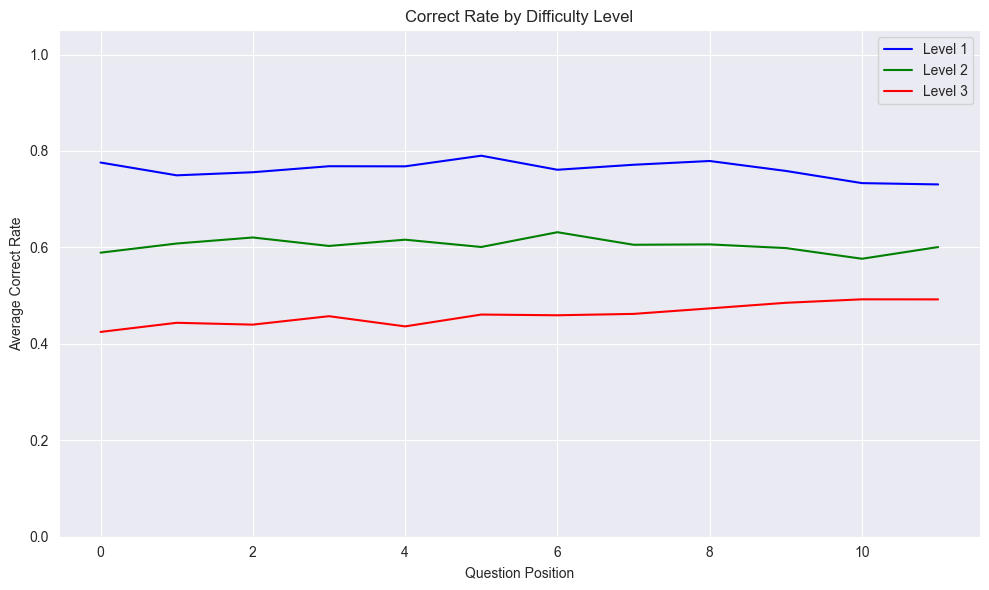

In [56]:
difficulty_labels = ['Level 1', 'Level 2', 'Level 3']
line_colors = ['blue', 'green', 'red']
length = len(output[0])
df = pd.DataFrame({
    'Question Index': list(range(length)),
    'Level 1': output[0],
    'Level 2': output[1],
    'Level 3': output[2]
})

# 畫折線圖
plt.figure(figsize=(10, 6))
for label, color in zip(difficulty_labels, line_colors):
    plt.plot(df['Question Index'], df[label], label=label, color=color)

plt.xlabel("Question Position")
plt.ylabel("Average Correct Rate")
plt.title("Correct Rate by Difficulty Level")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

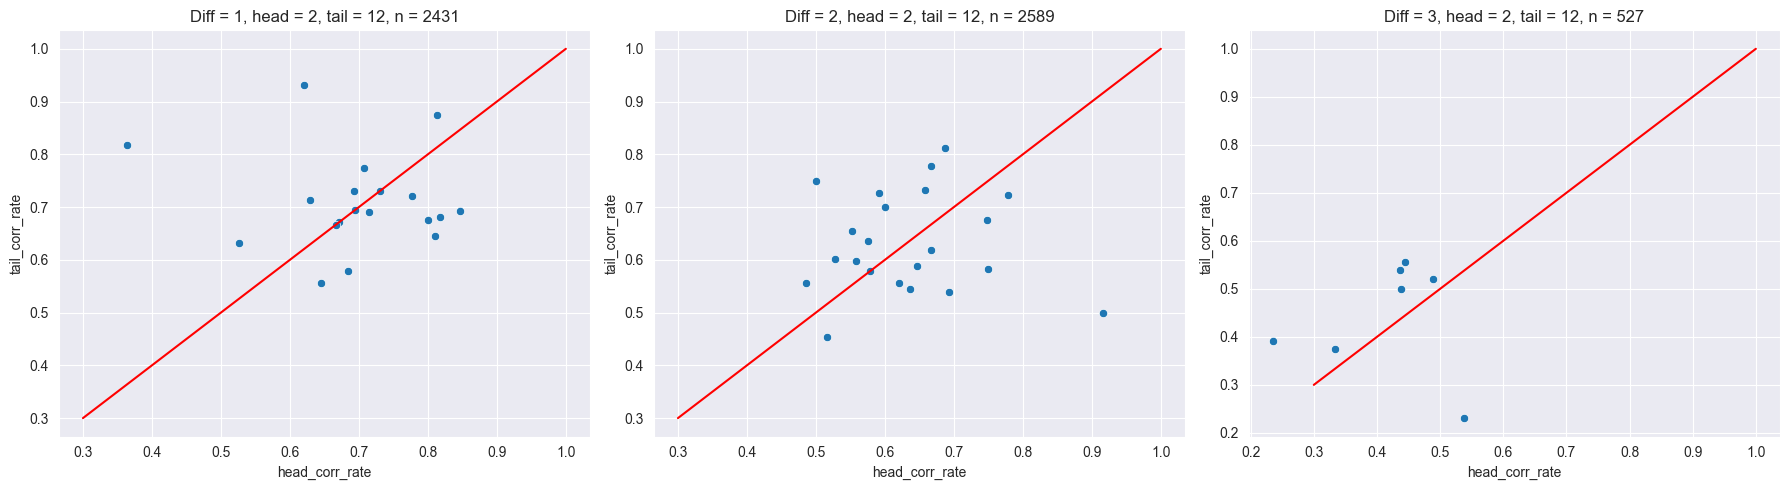

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def scatter_of_head_tail(df_: pd.DataFrame, head: int = 2, tail: int = 12, diff_level: int = 1, ax=None):
    df = df_.copy()

    h_temp, t_temp, hd_temp, td_temp = [], [], [], []

    for ans, diff in zip(df['is_correct'], df['difficulty_level']):
        if len(ans) > tail:
            h_temp.append(ans[head])
            t_temp.append(ans[tail])
            hd_temp.append(diff[head])
            td_temp.append(diff[tail])
        else:
            h_temp.append(np.nan)
            t_temp.append(np.nan)
            hd_temp.append(np.nan)
            td_temp.append(np.nan)

    df.loc[:, 'head_corr'] = h_temp
    df.loc[:, 'tail_corr'] = t_temp
    df.loc[:, 'head_diff'] = hd_temp
    df.loc[:, 'tail_diff'] = td_temp
    df.loc[:, 'section'] = df['section_id'].apply(lambda x: x[0])

    # 篩選符合指定難度的資料
    df = df[(df['head_diff'] == diff_level) & (df['tail_diff'] == diff_level)]

    # 分組計算
    scdf = df.groupby('section').agg(
        head_corr_rate=('head_corr', 'mean'),
        tail_corr_rate=('tail_corr', 'mean'),
        n=('head_corr', 'count')
    ).reset_index()

    # 使用傳入的 Axes 或新建
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # 畫圖
    sns.scatterplot(data=scdf[scdf['n'] > 10],
                    x='head_corr_rate',
                    y='tail_corr_rate',
                    ax=ax)

    seq = np.linspace(0.3, 1)
    ax.plot(seq, seq, color='red')
    ax.set_title(f"Diff = {diff_level}, head = {head}, tail = {tail}, n = {scdf['n'].sum()}")

    return ax


fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row 3 columns

for i in range(3):
    scatter_of_head_tail(testdfff[testdfff['answer_length'] >= 12], diff_level=i+1, ax=axes[i])

plt.tight_layout()
plt.show()


In [58]:

# analyze the correct rate in each order
def correct_rate(seqs: list[list]):
    print(len(seqs))
    output = []
    _maxlen = max(([len(seq) for seq in seqs]))
    for idx in range(_maxlen):
        temp = []
        for seq in seqs:
            if len(seq) > idx:
                temp.append(seq[idx])
        output.append(temp)
    mean = [statistics.mean(seq) for seq in output]
    se = [np.std(seq)/np.sqrt(len(seq)) if len(seq) > 1 else 0 for seq in output]
    n = [len(seq) for seq in output]

    return [mean, se, n]


exp_labels = testdfff['experiment_mode'].unique()
exp_labels.sort()

dfs = dict()
for lab in exp_labels:
    mask1 = testdfff['experiment_mode'] == lab if lab is not None else testdfff['experiment_mode'].isna()
    mask2 = 12 <= testdfff['answer_length']
    # mask3 = 5 < testdfff['answer_length']
    # mask = mask1 & mask2 & mask3
    mask = mask1 & mask2
    dfs[lab] = testdfff[mask]
    dfs[lab] = dfs[lab]

correct_rate_list = [correct_rate(dfs[key]['is_correct'].to_list()) for key in exp_labels]
correct_rate_mean = [_[0] for _ in correct_rate_list]
correct_rate_se = [_[1] for _ in correct_rate_list]
correct_rate_sample_size = [_[2] for _ in correct_rate_list]
print(exp_labels)

8100
1157
1242
1079
1056
[-1.  0.  1.  2.  3.]


<Figure size 6000x18000 with 0 Axes>

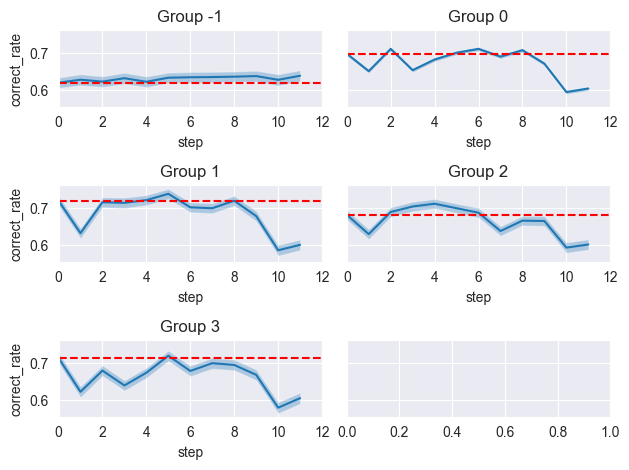

In [59]:

def plot_correct_rate_with_sd(correct_rate_seq, sd_seq=None, length_lim=None):
    plt.figure(figsize=(60,180))
    plt.subplots(3,2,sharey=True)
    for i in range(5):
        length = len(correct_rate_seq[i]) if length_lim is None else length_lim
        df = pd.DataFrame({
            'step': range(length),
            'correct_rate': correct_rate_seq[i][:length]
        })
        if sd_seq is not None:
            df['sd'] = sd_seq[i-1][:length_lim]
            df['upper'] = df['correct_rate'] + df['sd']
            df['lower'] = df['correct_rate'] - df['sd']

        plt.subplot(3, 2, i+1)
        sns.lineplot(data=df, x='step', y='correct_rate')
       # sns.regplot(data=df, x='step', y='correct_rate', scatter=False, ci=False)
        if sd_seq is not None:
            plt.fill_between(df['step'], df['lower'], df['upper'], alpha=0.3)
        plt.hlines(df.loc[0,'correct_rate'],xmin=0,xmax=length,colors='red',linestyles='dashed')
        plt.xlim([0, length_lim])
        plt.title(f"Group {i-1}")

    plt.tight_layout()
    plt.savefig('/Users/eric/Documents/SchoolCourses/PaGamO/data/results/5th_grades.png',dpi = 500)



# 僅畫線

#plot_correct_rate_with_sd(correct_rate_seq, sd_seq=correct_rate_se, length_lim=20)

plot_correct_rate_with_sd(correct_rate_mean,sd_seq=correct_rate_se,length_lim=12)

29387


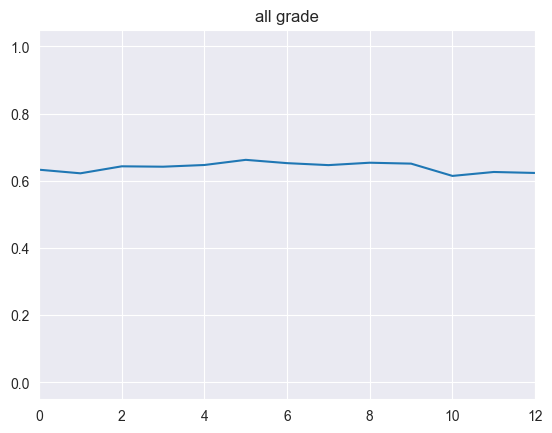

In [60]:
total = correct_rate(testdfff['is_correct'].to_list())


plt.xlim([0,12])
plt.plot(total[0])
plt.title('all grade')
plt.savefig('/Users/eric/Documents/SchoolCourses/PaGamO/data/results/5th_grade_agg.png',dpi = 500)

In [61]:
len(testdfff['is_correct'].to_list())

29387